[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/timpdotd/LabIAGI_1950722/tree/408d4077a2ed2906ba3a3145586fc761e9f4380e/Esercitazione_7)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/11ZNE3st9wB_-HpVV7gEEaUR04lw2JmB_?usp=sharing)

# Field test del MultiLayer Perceptron

Questo è il testo dell'esercitazione che dovrete completare per questa settimana. Non sarà guidato passo passo, ma
dovrete usare quello che avete imparato negli altri jupyter notebooks per addestrare dei modelli e cross-validarli,
al massimo delle vostre capacità.
I tre esercizi da svolgere sono:

1. addestrare un MLP su [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Potete utilizzare il codice
 del precedente notebook, ma vi consiglio di riscriverlo in maniera più ordinata. In questo caso, fate prima
 un'analisi dei dati per capire con cosa avete a che fare.
2. addestrare un MLP su [YearPredictionMSD](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD): l'idea di
      questo esercizio è quella di utilizzare una rete neurale per migliorare le performance rispetto alla soluzione
      che avete già implementato con la logistic regression nell'[esercitazione 6](https://github.com/Sapienza-AI-Lab/esercitazione6-22-23). In questo caso l'aspetto che ci
      preme esplorare è l'efficacia del MLP nell'imparare una rappresentazione (i.e. delle features) migliore per la
      classifcazione, o la regressione. Questo esercizion non è banale e sono interessato a vedere come sfrutterete
      le reti neurali per migliorare le prestazioni. Se non avete fatto l'EDA durante la scorsa esercitazione, questo è il momento di farla.
3. addestrare un MLP su CIFAR-10: riprenderemo questo dataset anche con le reti convoluzionali, ma iniziamo a
      farci un'idea delle sue caratterisitche addestrando im modello migliore possibile utilizzando un MLP. La sfida
      in questo caso sarà la dimensionalità dell'input, e quindi delle connessioni del MLP.


In tutti i casi tenete conto di questi aspetti:
* Non siete costretti ad usare i notebook. Personalmente non li amo, ma sono adatti a presentare il codice per la
    didattica. Per lavorare con progetti di una certa complessità è spesso meglio passare ad un normale progetto
    python. Ovviamente se non avete una GPU nel vostro portatile/desktop, l'unica soluzione è colab.
* Utilizzate tensorboard o weight and biases per la visualizzazione e per fare il debug del vostro modello. Non provate le cose a caso.

# MLP su YearPredictionMSD

---



## Import Libraries

In [1]:
%matplotlib inline
%reload_ext tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, ConcatDataset, TensorDataset

from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random

# This is when we use GPU instance to run colab.
# How to change Runtime in colab??
# Go to Runtime-> Change Runtime type -> Hardware Accelerator -> GPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Defining seed to make every experiment reproducible

In [2]:
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Load Dataset

In [3]:
# Dataset on github
url = 'https://media.githubusercontent.com/media/timpdotd/LabIAGI_1950722/main/Esercitazione_6/data/YearPredictionMSD.txt'

# Names of the features: the first is the year and the other 90 are timbres
features = ['year', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10',
            't11', 't12', 't13', 't14', 't15', 't16', 't17', 't18', 't19', 't20',
            't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28', 't29', 't30',
            't31', 't32', 't33', 't34', 't35', 't36 ', 't37', 't38', 't39', 't40',
            't41', 't42', 't43', 't44', 't45', 't46', 't47', 't48', 't49', 't50',
            't51', 't52', 't53' , 't54', 't55', 't56', 't57', 't58', 't59', 't60',
            't61', 't62', 't63', 't64', 't65', 't66', 't67', 't68', 't69', 't70',
            't71', 't72', 't73', 't74', 't75', 't76', 't77', 't78', 't79', 't80',
            't81', 't82', 't83', 't84', 't85', 't86', 't87', 't88', 't89', 't90']

df = pd.read_csv(url, names=features)
df.describe()

,year,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [4]:
df.shape

(515345, 91)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   year    515345 non-null  int64  
 1   t1      515345 non-null  float64
 2   t2      515345 non-null  float64
 3   t3      515345 non-null  float64
 4   t4      515345 non-null  float64
 5   t5      515345 non-null  float64
 6   t6      515345 non-null  float64
 7   t7      515345 non-null  float64
 8   t8      515345 non-null  float64
 9   t9      515345 non-null  float64
 10  t10     515345 non-null  float64
 11  t11     515345 non-null  float64
 12  t12     515345 non-null  float64
 13  t13     515345 non-null  float64
 14  t14     515345 non-null  float64
 15  t15     515345 non-null  float64
 16  t16     515345 non-null  float64
 17  t17     515345 non-null  float64
 18  t18     515345 non-null  float64
 19  t19     515345 non-null  float64
 20  t20     515345 non-null  float64
 21  t21     51

In [6]:
df.head()

,year,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


## Exploratory Data Analysis

Let's drop the NaN values

In [7]:
count_NaN = df.isna().sum().sum()

if count_NaN > 0:
  df = df.dropna
  print(f"Number of NaN dropped: {count_NaN}")
else:
  print("No NaN values")

No NaN values


Let's see how much songs I have each year

Text(0, 0.5, 'Number of songs')

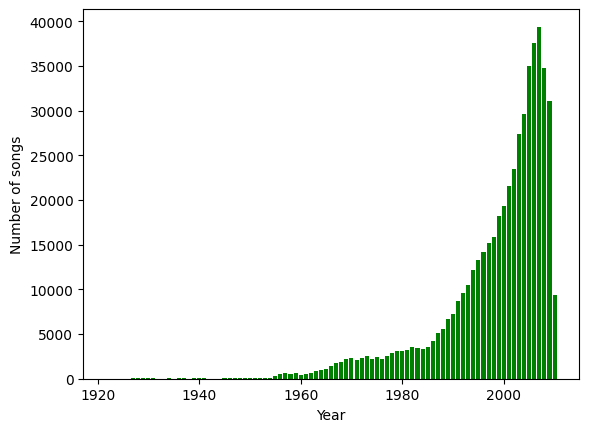

In [8]:
songs_in_year = {}
Y = df.iloc[:,0].values
years = range(min(Y), max(Y))
for y in years:
  songs_in_year[y] = len(df[df.year == y])
values = [songs_in_year[y] for y in years]
plt.bar(years, values, align='center', color='Green')
plt.xlabel('Year')
plt.ylabel('Number of songs')

## Splitting the dataset

Scaling the datase and splitting it

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = df.iloc[:,1:].values
Y = df.iloc[:,0].values

# Scaling X to have it from 0 to 1
X = scaler.fit_transform(X)
# Mapping Y from 0 to 89
Y = Y - np.min(Y)

# Dividing X and Y as reported in the dataset webpage
X_train = X[0:463715]
X_test = X[463715:]

y_train = Y[0:463715]
y_test = Y[463715:]

Converting it with pytorch and splitting into train, test and validation set

In [10]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Combine features and labels into a dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the batch size for training and validation
batch_size = 64

# Define the percentage of data to use for validation
validation_split = 0.2

# Calculate the split index for validation
split_index = int(len(train_dataset) * validation_split)
indices = list(range(len(train_dataset)))

# Split the indices into train and validation sets
train_indices = indices[split_index:]
valid_indices = indices[:split_index]

# Define samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check the size of each set
print("Train set size:", len(train_indices))
print("Validation set size:", len(valid_indices))
print("Test set size:", len(test_dataset))

Train set size: 370972
Validation set size: 92743
Test set size: 51630


# MLP su FashionMNIST

---



Validation set

In [ ]:
validation_set = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=False)
validation_set

Test set

In [ ]:
test_set = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
test_set

## Model

In [ ]:
"""
The MLP classifier
784 input units (images are 28 x 28)
3 hidden (256, 128, 100)
10 output (we have 10 classes)

Activation function: ReLU (Rectified Linear Unit). It's responsible of introducing
a non-linearity in the model. The main function is to determine the output of a node
or a set of nodes based on the input

Dropout 30%: randomly turn off 30% of the neurons of the input, giving us a
mechanism of regularization that prevents overfitting

Forward: generate a tensor of logaritmic probabilites associated to every class
for every record in the batch. These probabilities are obtained using log-softmax
in the final outpu
"""
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer_1 = nn.Linear(784, 256)
        self.activation_l1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 128)
        self.activation_l2 = nn.ReLU()
        self.layer_3 = nn.Linear(128, 100)
        self.activation_l3 = nn.ReLU()
        self.layer_4 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input images
        x = self.layer_1(x)
        x = self.activation_l1(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = self.activation_l2(x)
        x = self.dropout(x)
        x = self.layer_3(x)
        x = self.activation_l3(x)
        x = self.dropout(x)
        x = self.layer_4(x)
        return F.log_softmax(x, dim=1)

model = Classifier()

In [ ]:
"""
NLLLoss is commonly used in Classification tasks
SGD minimize the loss function regulating the model's parameters
"""
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()
print(model)

In [ ]:
"""
This function trains the neural network on each batch by resetting gradients,
performing forward pass, calculating loss, backpropagating gradients,
optimizing parameters using SGD, and printing training progress.
"""
def train(epoch, log_interval=200):
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.view(images.size(0), -1)  # Flatten the images
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(images),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item())
            )

In [ ]:
"""
This function validates the neural network by evaluating its performance on the
validation set. It calculates the loss and accuracy, appends them to the
respective vectors, and prints the validation results.
"""
def validate(loss_vector, accuracy_vector):
  model.eval()
  correct_count = 0
  incorrect_count = 0
  total_count = 0

  for images, labels in validation_loader:
    with torch.no_grad():
      images = images.view(images.shape[0], -1)
      outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    correct_count += (predicted == labels).sum().item()
    incorrect_count += (predicted != labels).sum().item()
    total_count += labels.size(0)

  accuracy = 100*(correct_count/total_count)
  loss = incorrect_count/total_count

  loss_vector.append(loss)
  accuracy_vector.append(accuracy)

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss,
        correct_count,
        total_count,
        accuracy)
  )

In [ ]:
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs+1):
  train(epoch)
  validate(lossv, accv)

Plot validation loss and accuracy side by side

In [ ]:
# Create subplots within a single figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot validation loss
axes[0].plot(np.arange(1, epochs + 1), lossv)
axes[0].set_title('Validation loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot validation accuracy
axes[1].plot(np.arange(1, epochs + 1), accv)
axes[1].set_title('Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

This code visualizes the model's predictions by displaying a set of images from the test set along with their predicted and true labels. It uses matplotlib to plot the images and labels, highlighting correct predictions in green and incorrect predictions in red.

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

#Get sample outputs
output = model(images)

_, preds = torch.max(output,1)

#Prep images for display
images = images.numpy()

#Plot the images in the batch along with the predicted and true labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))


plt.show()